## Load Dataset

In [1]:
from sklearn.datasets import fetch_lfw_people

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
print("Tipe objek lfw_people:", type(lfw_people))
print("Atribut dalam lfw_people:", dir(lfw_people))

Tipe objek lfw_people: <class 'sklearn.utils._bunch.Bunch'>
Atribut dalam lfw_people: ['DESCR', 'data', 'images', 'target', 'target_names']


In [4]:
n_samples, height, width = lfw_people.images.shape
n_features = height * width
n_classes = len(lfw_people.target_names)

print(f"Total Samples: {n_samples}")
print(f"Image Size: {height}x{width}")
print(f"Total Features (Flattened): {n_features}")
print(f"Total Classes: {n_classes}")
print(f"Class Names: {lfw_people.target_names}")

Total Samples: 1288
Image Size: 50x37
Total Features (Flattened): 1850
Total Classes: 7
Class Names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


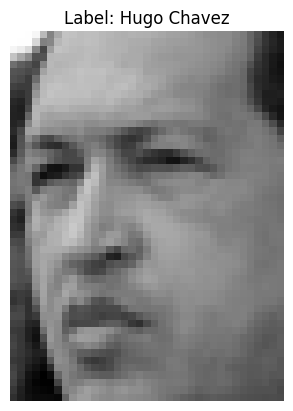

In [5]:
import matplotlib.pyplot as plt

sample_image = lfw_people.images[0]
sample_label = lfw_people.target[0]

plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {lfw_people.target_names[sample_label]}")
plt.axis('off')
plt.show()

## Splitting

In [6]:
from sklearn.model_selection import train_test_split

X = lfw_people.images.reshape(len(lfw_people.images), -1) #flatten
y = lfw_people.target
target_names = lfw_people.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1030, 1850), (258, 1850), (1030,), (258,))

## Cumulative Explained Variance

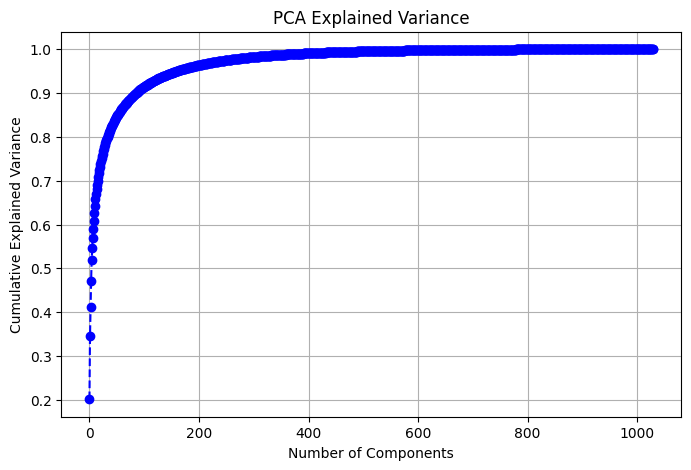

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(X_train)

plt.figure(figsize=(8, 5))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [8]:
n_components = (pca.explained_variance_ratio_.cumsum() >= 0.95).argmax() + 1
print(f"Jumlah komponen optimal untuk 95% varians: {n_components}")

Jumlah komponen optimal untuk 95% varians: 161


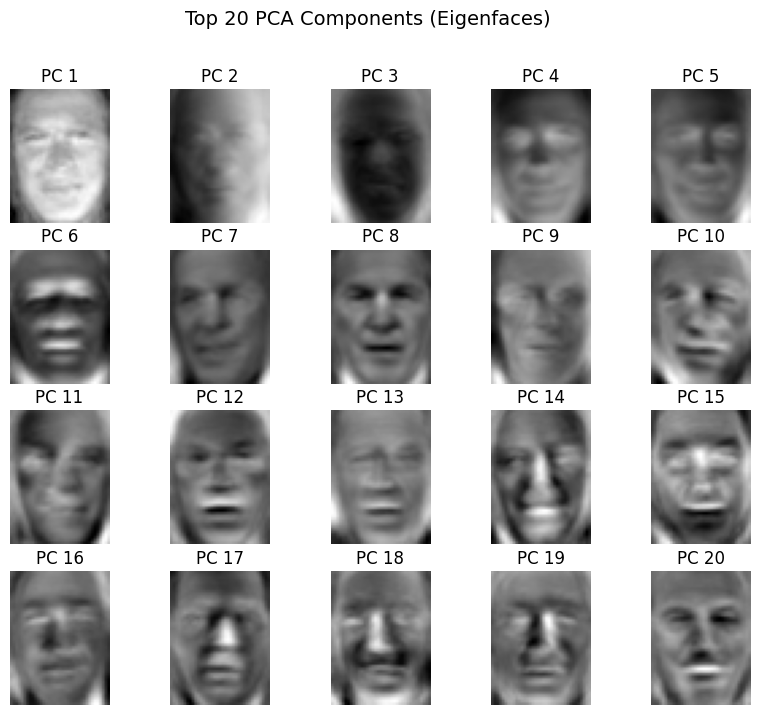

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=n_components, whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, lfw_people.images.shape[1], lfw_people.images.shape[2]))

fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f"PC {i+1}")
    ax.axis('off')

plt.suptitle("Top 20 PCA Components (Eigenfaces)", fontsize=14)
plt.show()

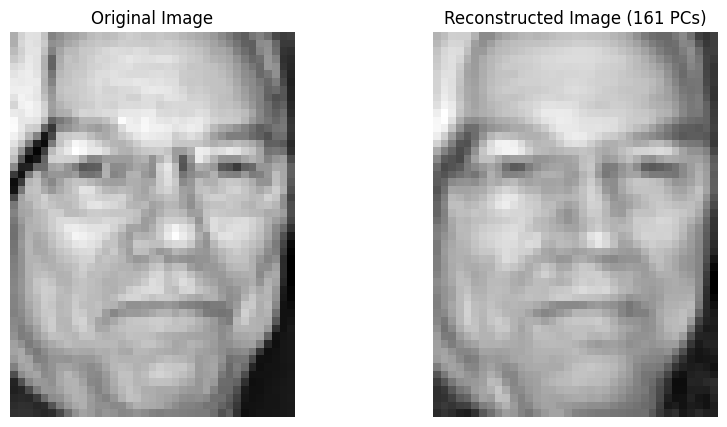

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=n_components, whiten=True).fit(X_train)

idx = 0
original_image = X_test[idx].reshape(lfw_people.images.shape[1], lfw_people.images.shape[2])

X_test_pca = pca.transform(X_test)
reconstructed_image = pca.inverse_transform(X_test_pca[idx]).reshape(lfw_people.images.shape[1], lfw_people.images.shape[2])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(reconstructed_image, cmap='gray')
ax[1].set_title(f"Reconstructed Image ({n_components} PCs)")
ax[1].axis('off')

plt.show()

## Training

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components, whiten=True)),
    ('algo', SVC(max_iter=500, probability=True))
])

parameter = {
    'algo__C': [0.1, 1, 10, 100],
    'algo__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'algo__degree': [2, 3, 4],
    'algo__gamma': ['scale', 'auto'],
    'algo__coef0': [0.0, 0.5, 1.0],
    'algo__max_iter': [500, 1000, 2000]
}

In [13]:
from sklearn.model_selection import RandomizedSearchCV

model = RandomizedSearchCV(pipeline, param_distributions=parameter, cv=5, scoring='accuracy', n_iter=10, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca',
                                              PCA(n_components=161,
                                                  whiten=True)),
                                             ('algo',
                                              SVC(max_iter=500,
                                                  probability=True))]),
                   n_jobs=-1,
                   param_distributions={'algo__C': [0.1, 1, 10, 100],
                                        'algo__coef0': [0.0, 0.5, 1.0],
                                        'algo__degree': [2, 3, 4],
                                        'algo__gamma': ['scale', 'auto'],
                                        'algo__kernel': ['linear', 'poly',
                                                         'rbf', 'sigmoid'],
                                        'algo__max_iter': [500, 1000, 2000]},
                   random_state=42, scoring='accuracy', verbose=1)

In [14]:
print(f"Best Parameters: {model.best_params_}")
print(f"Train Accuracy: {model.score(X_train, y_train)}")
print(f"Best CV Score: {model.best_score_}")
print(f"Test Accuracy: {model.score(X_test, y_test)}")

Best Parameters: {'algo__max_iter': 2000, 'algo__kernel': 'poly', 'algo__gamma': 'auto', 'algo__degree': 2, 'algo__coef0': 1.0, 'algo__C': 10}
Train Accuracy: 1.0
Best CV Score: 0.8300970873786409
Test Accuracy: 0.8488372093023255


## Evaluasi Model

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

print(f"Jumlah data train: {X_train.shape[0]}")
print(f"Jumlah data test: {X_test.shape[0]}\n")

print("**Evaluasi pada Data Train**")
print(f"Akurasi: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}\n")

print("**Evaluasi pada Data Test**")
print(f"Akurasi: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")


Jumlah data train: 1030
Jumlah data test: 258

**Evaluasi pada Data Train**
Akurasi: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

**Evaluasi pada Data Test**
Akurasi: 0.8488
Precision: 0.8534
Recall: 0.8488
F1-Score: 0.8450


In [16]:
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Classification Report - Train Data:")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report - Test Data:")
print(classification_report(y_test, y_test_pred))

Classification Report - Train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00       189
           2       1.00      1.00      1.00        97
           3       1.00      1.00      1.00       424
           4       1.00      1.00      1.00        87
           5       1.00      1.00      1.00        57
           6       1.00      1.00      1.00       115

    accuracy                           1.00      1030
   macro avg       1.00      1.00      1.00      1030
weighted avg       1.00      1.00      1.00      1030


Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.84      0.91      0.88        47
           2       0.76      0.79      0.78        24
           3       0.86      0.92      0.89       106
           4       0.81      0.77      0.79        22
      

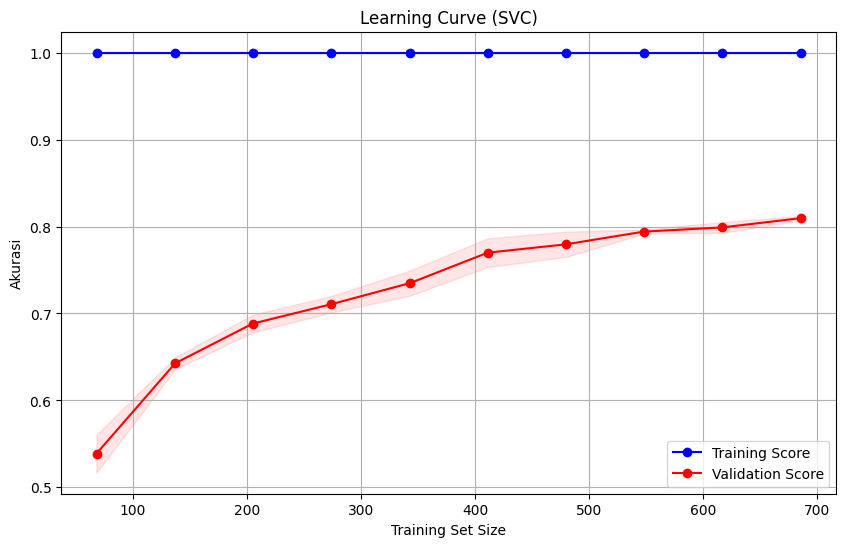

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

best_model = model.best_estimator_

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=3, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', color="red", label="Validation Score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="red")

plt.xlabel("Training Set Size")
plt.ylabel("Akurasi")
plt.title("Learning Curve (SVC)")
plt.legend()
plt.grid()
plt.show()

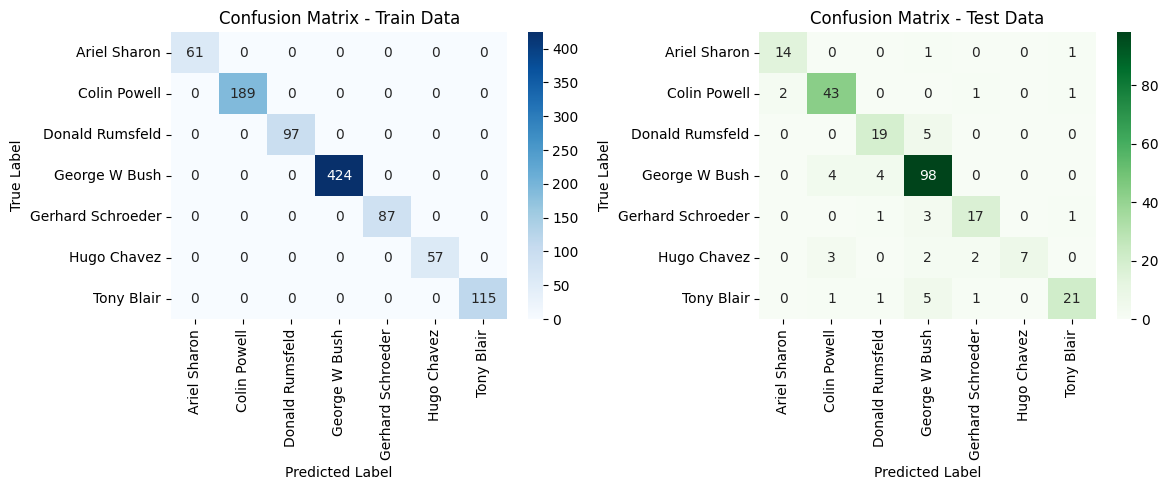

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_title("Confusion Matrix - Train Data")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Data")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

<ipython-input-18-f371bf5d6d84>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


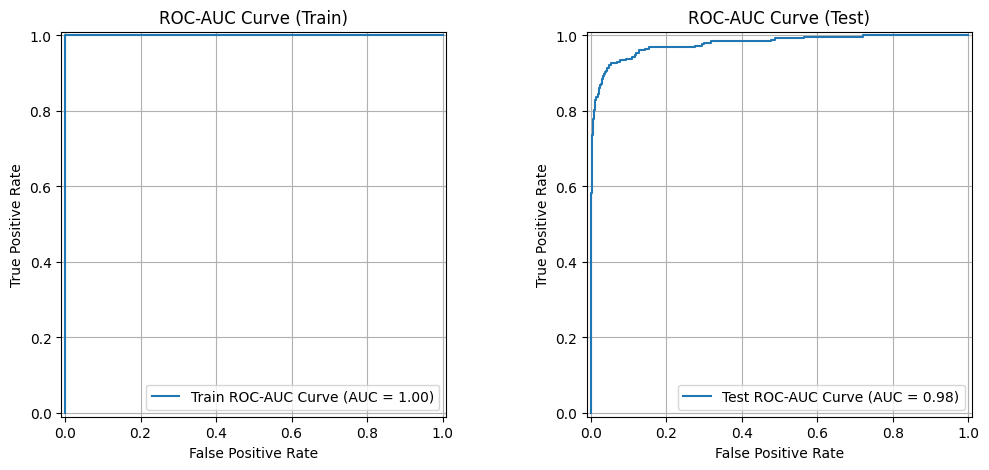

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train)
y_test_binarized = lb.transform(y_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.3})

y_train_flat = y_train_binarized.ravel()
y_train_score_flat = model.predict_proba(X_train).ravel()

fpr_train, tpr_train, _ = roc_curve(y_train_flat, y_train_score_flat)
roc_auc_train = auc(fpr_train, tpr_train)
display_train = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train)
display_train.plot(ax=ax[0], name="Train ROC-AUC Curve")
ax[0].set_title("ROC-AUC Curve (Train)")
ax[0].grid(True)

y_test_flat = y_test_binarized.ravel()
y_test_score_flat = model.predict_proba(X_test).ravel()

fpr_test, tpr_test, _ = roc_curve(y_test_flat, y_test_score_flat)
roc_auc_test = auc(fpr_test, tpr_test)
display_test = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test)
display_test.plot(ax=ax[1], name="Test ROC-AUC Curve")
ax[1].set_title("ROC-AUC Curve (Test)")
ax[1].grid(True)

plt.tight_layout()
plt.show()

<ipython-input-19-361ed5fdb426>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


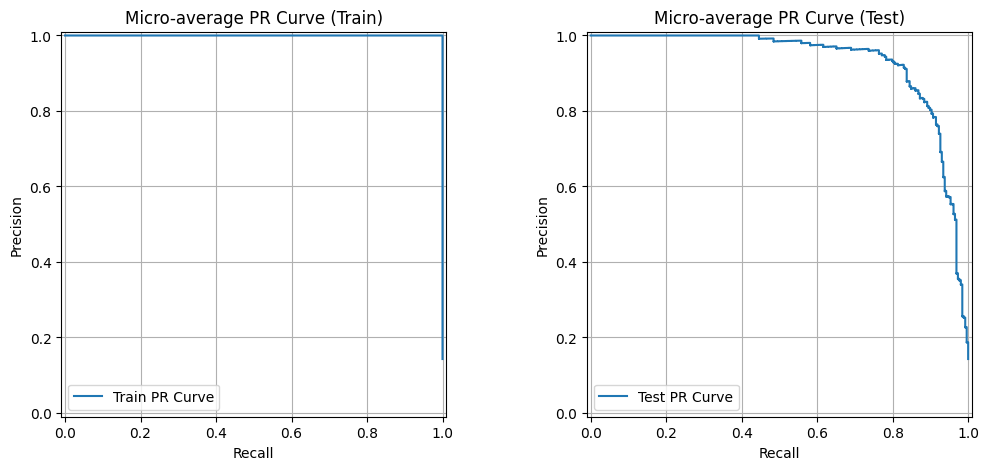

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train)
y_test_binarized = lb.transform(y_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.3})

y_train_flat = y_train_binarized.ravel()
y_train_score_flat = model.predict_proba(X_train).ravel()

precision_train, recall_train, _ = precision_recall_curve(y_train_flat, y_train_score_flat)
display_train = PrecisionRecallDisplay(precision=precision_train, recall=recall_train)
display_train.plot(ax=ax[0], name="Train PR Curve")
ax[0].set_title("Micro-average PR Curve (Train)")
ax[0].grid(True)

y_test_flat = y_test_binarized.ravel()
y_score_flat = model.predict_proba(X_test).ravel()

precision_test, recall_test, _ = precision_recall_curve(y_test_flat, y_score_flat)
display_test = PrecisionRecallDisplay(precision=precision_test, recall=recall_test)
display_test.plot(ax=ax[1], name="Test PR Curve")
ax[1].set_title("Micro-average PR Curve (Test)")
ax[1].grid(True)

plt.tight_layout()
plt.show()

## Prediksi data Test

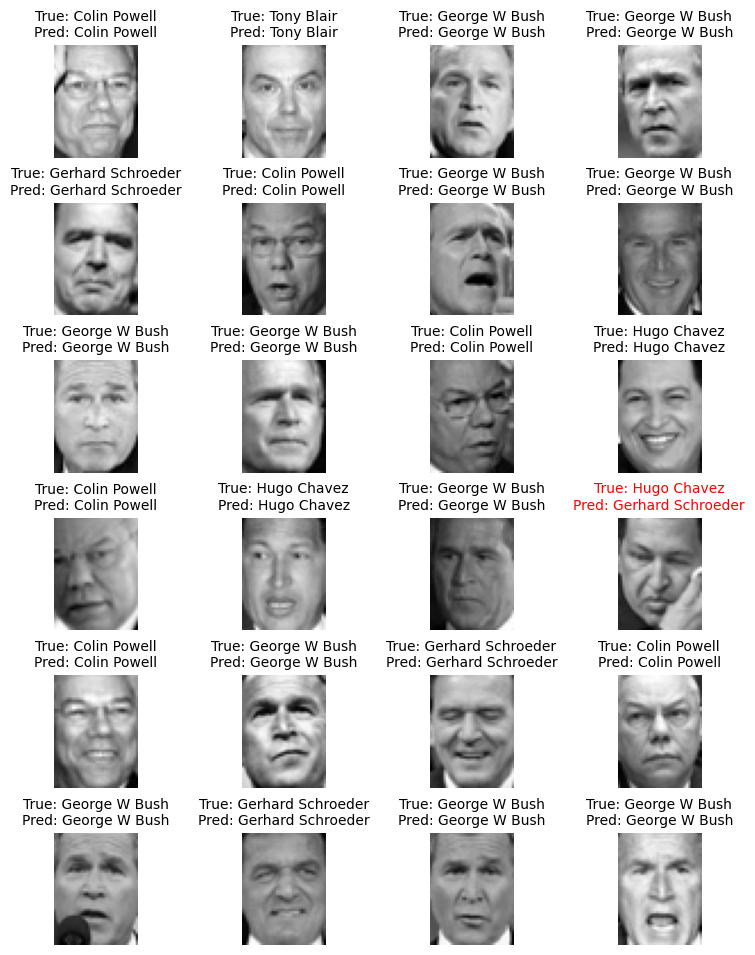

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 4, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    if i < len(X_test):
        img = X_test[i].reshape(lfw_people.images.shape[1], lfw_people.images.shape[2])
        true_label = target_names[y_test[i]]
        pred_label = target_names[model.predict([X_test[i]])[0]]

        title_color = "red" if true_label != pred_label else "black"

        ax.imshow(img, cmap='gray')
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color=title_color)
        ax.axis('off')
    else:
        ax.axis('off')

plt.subplots_adjust(left=0.02, right=0.50, top=0.95, bottom=0.05, wspace=0.2, hspace=0.4)
plt.show()